## 14.2 ポアソン回帰
```statsmodels```と```sklearn```を用いたポアソン回帰のスニペット。

```sklearn```のエラーを解消できていない。

### (共通)データの読み込み
```seaborn```の```tips```データセットを用いる。

NumBedrooms,HouseCosts,OwnRent
i64,i64,str
4,1800,"""Mortgage"""
4,2600,"""Mortgage"""
3,860,"""Mortgage"""
3,270,"""Mortgage"""
3,710,"""Mortgage"""


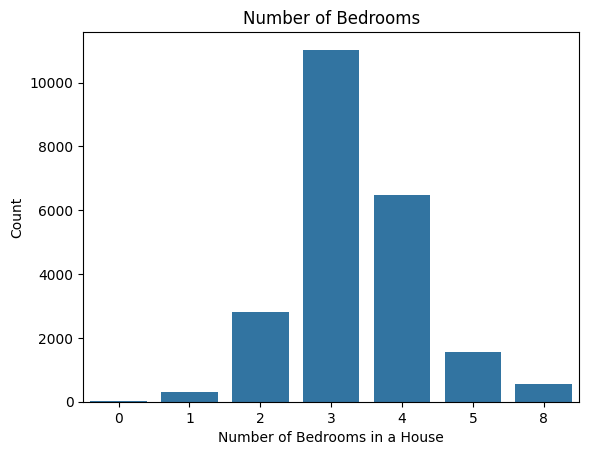

In [17]:
import polars as pl
pl.Config.set_tbl_cols(-1)
import seaborn as sns

# データの読み込み
acs = pl.read_csv("../data/acs_ny.csv")
acs_subset = acs[["NumBedrooms", "HouseCosts", "OwnRent"]].sort(by = "OwnRent")
display(acs_subset.head())

# 
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.countplot(data = acs, x = "NumBedrooms", ax = ax)

ax.set_title("Number of Bedrooms")
ax.set_xlabel("Number of Bedrooms in a House")
ax.set_ylabel("Count")

plt.show()

### 14.1.1 statsmodels

In [18]:
import statsmodels.formula.api as smf

# モデルを学習する
form = "NumBedrooms ~ HouseCosts + OwnRent"
model = smf.poisson(formula = form, data = acs_subset).fit()

# 学習結果を表示する
display(model.summary())

Optimization terminated successfully.
         Current function value: 1.680998
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:            NumBedrooms   No. Observations:                22745
Model:                        Poisson   Df Residuals:                    22741
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Jan 2024   Pseudo R-squ.:                0.008309
Time:                        17:38:41   Log-Likelihood:                -38234.
converged:                       True   LL-Null:                       -38555.
Covariance Type:            nonrobust   LLR p-value:                1.512e-138
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1387      0.006    184.928      0.000       1.127       1.151
OwnRent[T.Outright]    -0.2659      0.051     -5.182      0.000      -0.367      -0.165
OwnRent[T.Rented]      -0.1237      0.012     -9.996      0.000      -0.148      -0.099
HouseCosts           6.217e-05   2.96e-06     21.017      0.000    5.64e-05     6.8e-05
=======================================================================================
"""

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 一般化線形モデルの場合
# モデルを学習する
form = "NumBedrooms ~ HouseCosts + OwnRent"
model = (
    smf.glm(
        formula = form,
        data = acs_subset,
        family = sm.families.Poisson(sm.genmod.families.links.log())
    ).fit()
)

# 学習結果を表示する
display(model.summary())

c:\Python311\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            NumBedrooms   No. Observations:                22745
Model:                            GLM   Df Residuals:                    22741
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38234.
Date:                Mon, 01 Jan 2024   Deviance:                       6839.2
Time:                        17:38:41   Pearson chi2:                 7.32e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02778
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1387      0.006    184.928      0.000       1.127       1.151
OwnRent[T.Outright]    -0.2659      0.051     -5.182      0.000      -0.367      -0.165
OwnRent[T.Rented]      -0.1237      0.012     -9.996      0.000      -0.148      -0.099
HouseCosts           6.217e-05   2.96e-06     21.017      0.000    5.64e-05     6.8e-05
=======================================================================================
"""

### 14.1.2 sklearn

In [20]:
from sklearn import linear_model

# ダミー変数を作成する
import polars.selectors as cs
# 数値型は外しておく
df_numeric = acs_subset.select(cs.numeric()).drop("NumBedrooms")
# カテゴリ変数のみダミー変数を作成する
df_categorical = acs_subset.select(cs.string())
df_dummy = df_categorical.to_dummies(drop_first = True)
# 学習用のDataFrameを作成する
df_study = pl.concat(items = [df_numeric, df_dummy], how = "horizontal")
display(df_study.head())

# モデルを学習する
lr = linear_model.PoissonRegressor()
model = lr.fit(X = df_study, y = acs_subset["NumBedrooms"])


# 学習結果を表示する
import numpy as np
# 係数の名称
labels = ["Intercept"]
for col in df_study.columns:
    labels.append(col)
# 係数
coefficients = np.append(
    model.intercept_, model.coef_
)
# 学習結果
result = pl.DataFrame({
    "Label": labels,
    "Coefficient": coefficients
})
print(result)

HouseCosts,OwnRent_Outright,OwnRent_Rented
i64,u8,u8
1800,0,0
2600,0,0
860,0,0
270,0,0
710,0,0


shape: (4, 2)
┌──────────────────┬─────────────┐
│ Label            ┆ Coefficient │
│ ---              ┆ ---         │
│ str              ┆ f64         │
╞══════════════════╪═════════════╡
│ Intercept        ┆ 1.219447    │
│ HouseCosts       ┆ 0.0         │
│ OwnRent_Outright ┆ 0.0         │
│ OwnRent_Rented   ┆ 0.0         │
└──────────────────┴─────────────┘


c:\Python311\Lib\site-packages\sklearn\linear_model\_linear_loss.py:290: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
